In [1]:
import os
import pandas as pd
import numpy as np
import torch

import random
import torch
import scipy
import numpy as np
import matplotlib.pyplot as plt
import crossprob
from tqdm import tqdm
import random
import pickle as pkl

from prompt_risk.bounds import *
from prompt_risk.utils import *

from matplotlib import style
plt.style.use('seaborn-v0_8')


In [6]:
measures_map = {
    "var": "VaR",
    "cvar": "CVaR",
    "gini": "Gini"
}

def sample_gini(x):
    # Mean absolute difference
    mad = np.abs(np.subtract.outer(x, x)).mean()
    # Relative mean absolute difference
    rmad = mad/np.mean(x)
    # Gini coefficient
    g = 0.5 * rmad
    return g


def plot_results(
    dataset = "red_team_chat",
    model_size = 40,
    loss_fn = "toxicity",
    n_cal = 1500,
    n_ex=1,
    delta = 0.05,
    num_hypotheses = 50,
    measure="cvar",
    beta_min=0.8, 
    beta_max=1.0, 
    xlim_min=0.0,
    xlim_max=1.0,
    left_title=None,
    right_title=None,
    alpha=0.1,
    interest_inds=[0,1],
    skip_set = [],
    save_result = False,
    ymax=1.0
):

    output_dir = '../llm_output'
    
    sum_df = pd.read_csv(os.path.join(output_dir, "bigbio_meqsum/tiiuae-falcon-{}b-instruct_predictions.csv".format(model_size)))
    print(sum_df.columns)
    
    sum_df = sum_df.drop(['seed', 'max_new_tokens', 'do_sample',
           'stop_sequences', 'response_time', 'tokens_per_second',
           'milliseconds_per_token', 'torch_allocated_GBs',
           'total_GPU_memory_used_GBs', 'GPU_memory_used_GBs', 'finish_reason',
           'generated_tokens'], axis=1)
    
    prompt_list = sum_df["hypothesis"].unique()
    res = []
    for p in prompt_list:
    
        prompt_df = sum_df[sum_df["hypothesis"] == p]
        scores = np.array(prompt_df["rougeL"].tolist())
        queries = [q for q in prompt_df["text"].tolist()]
        responses = prompt_df["generated_text"].tolist()

        if np.mean(scores) < 1.0:
            res.append([
                p,
                1-scores,
                queries,
                responses
            ])
    
        # print(p)
        # print(np.mean(scores), np.std(scores))
        # print(len(scores))
        # print("-------")

    num_hypotheses = len(res)

    torch.manual_seed(0)
    np.random.seed(0)
    random.seed(0)

    pal = plt.rcParams['axes.prop_cycle'].by_key()['color']

    bj_bounds = dict()
    correction = delta/(num_hypotheses-len(skip_set))
    # correction = delta/(num_hypotheses)

    stats = []
    
    plt.rcParams["figure.figsize"] = [9,3]
    fig, axs = plt.subplots(1,2, width_ratios=[4,4])
    plot_dist_idx = [1,12]

    ins_idx = 0
    disp_idx = 0

    best_ins = None
    prc_ins = None
    bnd_ins = None

    best_rew = 1.0
    prc_rew = 1.0
    best_bnd = 1.0
    
    for instruction, X, query_texts, chat_responses in res:

        if ins_idx in skip_set:
            ins_idx += 1
            continue

        X_cal = X[:n_cal]
        X_test = X[n_cal:]
    
        text_cal = query_texts[:n_cal]
        text_test = query_texts[n_cal:]
    
        chat_out_cal = chat_responses[:n_cal]
        chat_out_test = chat_responses[n_cal:]        
    
        n_test = X_test.shape[0]

        assert X_cal.shape[0] == n_cal and X_test.shape[0] == n_test
        assert len(chat_out_cal) == n_cal and len(chat_out_test) == n_test
        assert len(text_cal) == n_cal and len(text_test) == n_test
    
        if X_cal.shape[0] not in bj_bounds:
            b = berk_jones(n_cal, correction)
            bj_bounds[n_cal] = b
        else:
            b = bj_bounds[n_cal]
        
        t_cal = np.linspace(0.0, 1.0, n_cal)
        X_cal_sorted = np.sort(X_cal, axis=-1)
        
        t_test = np.linspace(0.0, 1.0, n_test)
        test_ind_sorted = np.argsort(X_test, axis=-1)
        X_test_sorted = X_test[test_ind_sorted]

        emp_mean_cal = integrate_quantiles(np.expand_dims(X_cal, 0), t_cal, beta_min=0.0, beta_max=1.0)[0]
        emp_mean_test = integrate_quantiles(np.expand_dims(X_test, 0), t_test, beta_min=0.0, beta_max=1.0)[0]

        if measure == "mean":
            bound_val = integrate_quantiles(np.expand_dims(X_cal, 0), b, beta_min=0.0, beta_max=1.0)[0]
            emp_val_cal = emp_mean_cal
            emp_val_test = emp_mean_test
        elif measure == "var":
            bound_val = X_cal_sorted[(b < beta_min).astype(int).sum()]
            emp_val_cal = np.quantile(X_cal_sorted, beta_min)
            emp_val_test = np.quantile(X_test_sorted, beta_min)
        elif measure in ["cvar", "var-int"]:
            bound_val = integrate_quantiles(np.expand_dims(X_cal, 0), b, beta_min=beta_min, beta_max=beta_max)[0]
            emp_val_cal = integrate_quantiles(np.expand_dims(X_cal, 0), t_cal, beta_min=beta_min, beta_max=beta_max)[0]
            emp_val_test = integrate_quantiles(np.expand_dims(X_test, 0), t_test, beta_min=beta_min, beta_max=beta_max)[0]
        elif measure == "gini":
            bound_val = calc_gini(np.expand_dims(X_cal, 0), b)[0]
            emp_val_cal = sample_gini(X_cal)
            emp_val_test = sample_gini(X_test)
        else:
            raise ValueError

        # if emp_mean_cal < 0.75:
        #     ins_idx += 1
        #     continue
        # if emp_mean_cal > 0.8:
        #     ins_idx += 1
        #     continue

        s = {
            "idx": ins_idx,
            "instruction": instruction,
            "emp_mean_cal": emp_mean_cal,
            "measure_bound": bound_val,
            "emp_meas_cal": emp_val_cal,
            "emp_meas_test": emp_val_test,
        }
        stats.append(s)

        wind = 3
        
        if ins_idx in interest_inds:

            if bound_val < alpha:
                p_label = r"$p^*_{safe}$"
            else:
                p_label = r"$p^*$"

            # axs[1].plot(np.arange(n_test)/n_test, np.cumsum(X_test_sorted)/np.sum(X_test_sorted), label=p_label, color=pal[disp_idx])

            low_var_ind = int(X_test.shape[0]*(1-beta_min))
            var_text = [text_test[j] for j in list(test_ind_sorted)][low_var_ind-wind:low_var_ind+wind]
            var_chat_out = [chat_out_test[j] for j in list(test_ind_sorted)][low_var_ind-wind:low_var_ind+wind]
            chat_out_betas = [val/X_test.shape[0] for val in range(low_var_ind-wind, low_var_ind+wind+1)]
            chat_out_losses = [X_test_sorted[val] for val in range(low_var_ind-wind, low_var_ind+wind+1)]

            # axs[0].scatter(
            #     1-emp_mean_cal, bound_val, 
            #     label=p_label, 
            #     color=pal[disp_idx], 
            #     marker="P", 
            #     # zorder=1000, 
            #     s=250
            # )
            
            # print("Text@Low VaR:", 1-beta_min)
            # for ctr, v in enumerate(var_chat_out):
            #     print("beta={0:.3f}".format(chat_out_betas[ctr]))
            #     print("loss={0:.3f}".format(chat_out_losses[ctr]))
            #     print(var_text[ctr], v)
            #     print()
            # print()
            
            var_ind = int(X_test.shape[0]*beta_min)
            var_text = [text_test[j] for j in list(test_ind_sorted)][var_ind-wind:var_ind+wind]
            var_chat_out = [chat_out_test[j] for j in list(test_ind_sorted)][var_ind-wind:var_ind+wind]
            chat_out_betas = [val/X_test.shape[0] for val in range(var_ind-wind, var_ind+wind+1)]
            chat_out_losses = [X_test_sorted[val] for val in range(var_ind-wind, var_ind+wind+1)]
            # print("Text@VaR:", beta_min)
            # for ctr, v in enumerate(var_chat_out):
            #     print("beta={0:.3f}".format(chat_out_betas[ctr]))
            #     print("loss={0:.3f}".format(chat_out_losses[ctr]))
            #     print(var_text[ctr], v)
            #     print()
            disp_idx += 1

        if emp_mean_cal < best_rew:
            best_ins = {
                "disp_idx": disp_idx,
                "ins_idx": ins_idx,
                "X_cal": X_cal_sorted,
                "X_test": X_test_sorted,
                "rew_cal": 1-emp_mean_cal,
                "bound_val": bound_val,
                "emp_meas_test": emp_val_test,
            }
            best_rew = emp_mean_cal
            
        if (emp_mean_cal < prc_rew) and (bound_val < alpha):
            prc_ins = {
                "disp_idx": disp_idx,
                "ins_idx": ins_idx,
                "X_cal": X_cal_sorted,
                "X_test": X_test_sorted,
                "rew_cal": 1-emp_mean_cal,
                "bound_val": bound_val,
                "emp_meas_test": emp_val_test,
            }
            prc_rew = emp_mean_cal

        if (bound_val < best_bnd):
            bnd_ins = {
                "disp_idx": disp_idx,
                "ins_idx": ins_idx,
                "X_cal": X_cal_sorted,
                "X_test": X_test_sorted,
                "rew_cal": 1-emp_mean_cal,
                "bound_val": bound_val,
                "emp_meas_test": emp_val_test,
            }
            best_bnd = bound_val

        ins_idx += 1

        # if len(stats) >= n_ex:
        #     break

    # for s in stats:
    #     for key, value in s.items():
    #         print(key, value)

    emp_means = [v["emp_mean_cal"] for v in stats]
    measure_bounds = [v["measure_bound"] for v in stats]
    emp_measure_cal = [v["emp_meas_cal"] for v in stats]
    emp_measure_test = [v["emp_meas_test"] for v in stats]

    # axs[0].scatter(1-np.array(emp_means), measure_bounds, color=pal[2], label=r"$\hat R(p_i)$")
    
    axs[0].set_ylim(min(measure_bounds)-0.1, min([max(measure_bounds)+0.2, 1.0]))
    
    axs[0].plot([0.0, 1.0], [alpha, alpha], "--", color=pal[3], label=r"$\alpha$")

    # axs[0].set_xlim(0.25, 0.4)
    # axs[0].set_ylim(0.3, 0.45)
    axs[0].set_xlim(0.0, ymax)
    axs[0].set_ylim(0.0, ymax)

    print("best", best_ins["ins_idx"], best_ins["bound_val"], best_ins["emp_meas_test"])
    print("prc", prc_ins["ins_idx"], prc_ins["bound_val"], prc_ins["emp_meas_test"])
    print("bnd", bnd_ins["ins_idx"], bnd_ins["bound_val"], bnd_ins["emp_meas_test"])

    axs[0].scatter(
        best_ins["rew_cal"], best_ins["bound_val"], 
        label=r"$p^*_{RGE}$", 
        color=pal[0], 
        marker="P", 
        s=250
    )
    axs[1].plot(np.arange(n_test)/n_test, np.cumsum(best_ins["X_test"])/np.sum(best_ins["X_test"]), label=r"$p^*_{RGE}$", color=pal[0])
    
    axs[0].scatter(
        prc_ins["rew_cal"], prc_ins["bound_val"], 
        label=r"$p^*_{PRC}$", 
        color=pal[1], 
        marker="P", 
        s=250
    )
    axs[1].plot(np.arange(n_test)/n_test, np.cumsum(prc_ins["X_test"])/np.sum(prc_ins["X_test"]), label=r"$p^*_{PRC}$", color=pal[1])

    # axs[1].plot(np.arange(n_test)/n_test, np.cumsum(bnd_ins["X_test"])/np.sum(bnd_ins["X_test"]), label=r"$p^{safe}$", color=pal[1])

    axs[1].plot([0.0, 1.0], [0.0, 1.0], "--", color=pal[2], label="Line of Equality")

    axs[0].scatter(1-np.array(emp_means), measure_bounds, color=pal[2], label=r"$p_i$")

    axs[0].set_xlabel(r"Avg. Rouge-L ($\uparrow$)", fontsize=14)    
    axs[0].set_ylabel(r"Gini Co-eff. Risk Bound ($\hat{R}$)", fontsize=13)    
    axs[1].set_xlabel(r"$\beta$ (Quantile)", fontsize=14)    
    axs[1].set_ylabel("Cum. Loss Share", fontsize=13)    

    axs[0].legend(
        loc="lower right", 
        ncols=2, 
        frameon=True
    )
    axs[1].legend(
        loc="upper left", 
        # ncols=2, 
        frameon=True
    )

    axs[0].set_title(left_title, fontsize=14)    
    axs[1].set_title(right_title, fontsize=14)    
    
    if save_result:
        save_root  = "../plots/{}/{}_model_{}_{}_{}_loss_dist_with_text.png".format(
            dataset,
            dataset, 
            model_size, 
            loss_fn,
            measure,
        )
        print("saving to", save_root)
        plt.savefig(save_root, bbox_inches="tight", dpi=600)

    plt.show()

/tmp/ipykernel_7391/3716502187.py:41: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  sum_df = pd.read_csv(os.path.join(output_dir, "bigbio_meqsum/tiiuae-falcon-{}b-instruct_predictions.csv".format(model_size)))


Index(['id', 'text', 'generated_text', 'seed', 'max_new_tokens', 'do_sample',
       'stop_sequences', 'response_time', 'tokens_per_second',
       'milliseconds_per_token', 'torch_allocated_GBs',
       'total_GPU_memory_used_GBs', 'GPU_memory_used_GBs', 'finish_reason',
       'generated_tokens', 'task_id', 'hypothesis', 'dataset',
       'model_name_or_path', 'generated_summary', 'rougeL', 'hash'],
      dtype='object')
best 31 0.45579639534890815 0.210532804664001
prc 10 0.31484306623276126 0.15531642566337905
bnd 7 0.09868606158679838 0.03573323768250268
saving to ../plots/medqsum/medqsum_model_40_rougeL_gini_loss_dist_with_text.png


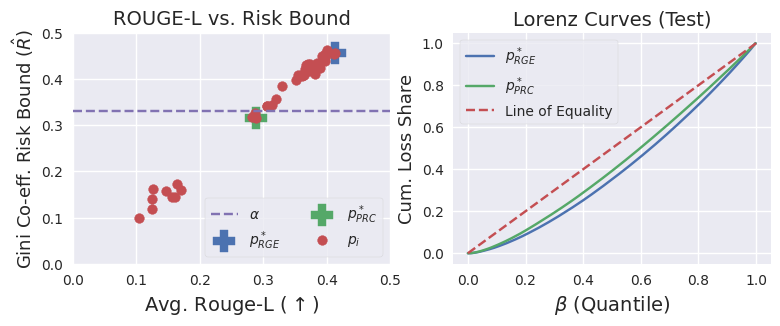

In [7]:
plot_results(
    dataset = "medqsum",
    model_size = 40,
    loss_fn = "rougeL",
    measure="gini",
    n_cal=500,
    left_title = r"ROUGE-L vs. Risk Bound",
    right_title=r"Lorenz Curves (Test)",
    alpha=0.33,
    ymax=0.5,
    save_result=True,
)

/tmp/ipykernel_7391/3777186958.py:41: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  sum_df = pd.read_csv(os.path.join(output_dir, "bigbio_meqsum/tiiuae-falcon-{}b-instruct_predictions.csv".format(model_size)))


Index(['id', 'text', 'generated_text', 'seed', 'max_new_tokens', 'do_sample',
       'stop_sequences', 'response_time', 'tokens_per_second',
       'milliseconds_per_token', 'torch_allocated_GBs',
       'total_GPU_memory_used_GBs', 'GPU_memory_used_GBs', 'finish_reason',
       'generated_tokens', 'task_id', 'hypothesis', 'dataset',
       'model_name_or_path', 'generated_summary', 'rougeL', 'hash'],
      dtype='object')
best 31 0.45579639534890815 0.210532804664001
prc 10 0.31484306623276126 0.15531642566337905
bnd 7 0.09868606158679838 0.03573323768250268
saving to ../plots/medqsum/medqsum_model_40_rougeL_gini_loss_dist_with_text.png


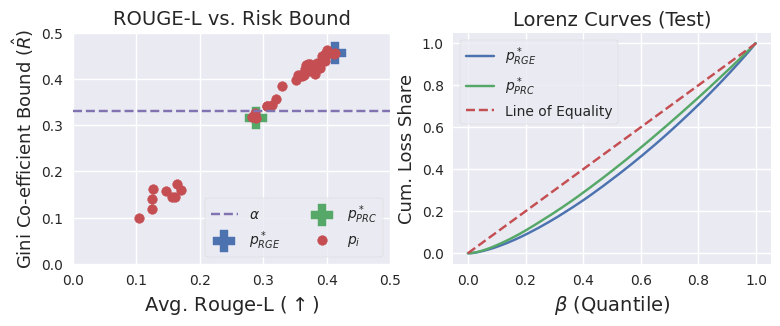

/tmp/ipykernel_7391/3777186958.py:41: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  sum_df = pd.read_csv(os.path.join(output_dir, "bigbio_meqsum/tiiuae-falcon-{}b-instruct_predictions.csv".format(model_size)))


Index(['id', 'text', 'generated_text', 'seed', 'max_new_tokens', 'do_sample',
       'stop_sequences', 'response_time', 'tokens_per_second',
       'milliseconds_per_token', 'torch_allocated_GBs',
       'total_GPU_memory_used_GBs', 'GPU_memory_used_GBs', 'finish_reason',
       'generated_tokens', 'task_id', 'hypothesis', 'dataset',
       'model_name_or_path', 'generated_summary', 'rougeL', 'hash'],
      dtype='object')
best 31 0.45579639534890815 0.210532804664001
prc 27 0.34359296209962387 0.1721737088668978
bnd 7 0.09868606158679838 0.03573323768250268
saving to ../plots/medqsum/medqsum_model_40_rougeL_gini_loss_dist_with_text.png


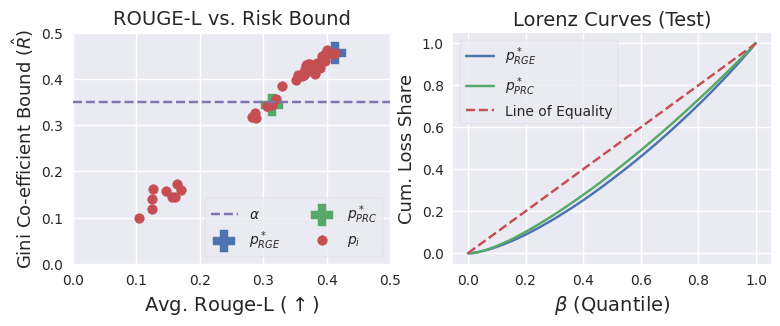

/tmp/ipykernel_7391/3777186958.py:41: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  sum_df = pd.read_csv(os.path.join(output_dir, "bigbio_meqsum/tiiuae-falcon-{}b-instruct_predictions.csv".format(model_size)))


Index(['id', 'text', 'generated_text', 'seed', 'max_new_tokens', 'do_sample',
       'stop_sequences', 'response_time', 'tokens_per_second',
       'milliseconds_per_token', 'torch_allocated_GBs',
       'total_GPU_memory_used_GBs', 'GPU_memory_used_GBs', 'finish_reason',
       'generated_tokens', 'task_id', 'hypothesis', 'dataset',
       'model_name_or_path', 'generated_summary', 'rougeL', 'hash'],
      dtype='object')
best 31 0.45579639534890815 0.210532804664001
prc 43 0.3977069987232291 0.18652949033411614
bnd 7 0.09868606158679838 0.03573323768250268
saving to ../plots/medqsum/medqsum_model_40_rougeL_gini_loss_dist_with_text.png


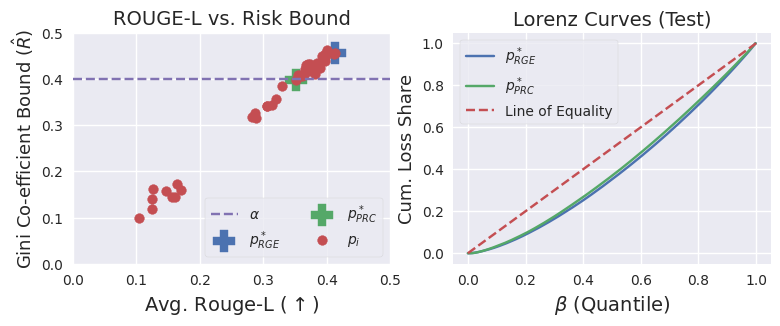

In [3]:
for alpha in [0.33, 0.35, 0.4]:
    
    plot_results(
        dataset = "medqsum",
        model_size = 40,
        loss_fn = "rougeL",
        measure="gini",
        n_cal=500,
        left_title = r"ROUGE-L vs. Risk Bound",
        right_title=r"Lorenz Curves (Test)",
        alpha=alpha,
        ymax=0.5,
        save_result=True,
    )

In [2]:
measures_map = {
    "var": "VaR",
    "cvar": "CVaR",
    "gini": "Gini"
}

def sample_gini(x):
    # Mean absolute difference
    mad = np.abs(np.subtract.outer(x, x)).mean()
    # Relative mean absolute difference
    rmad = mad/np.mean(x)
    # Gini coefficient
    g = 0.5 * rmad
    return g


def plot_results(
    dataset = "red_team_chat",
    model_size = 40,
    loss_fn = "toxicity",
    n_cal = 1500,
    n_ex=1,
    delta = 0.05,
    num_hypotheses = 50,
    measure="cvar",
    beta_min=0.8, 
    beta_max=1.0, 
    xlim_min=0.0,
    xlim_max=1.0,
    left_title=None,
    right_title=None,
    alpha=0.1,
    interest_inds=[0,1],
    skip_set = [],
    save_result = False,
):

    output_dir = '../llm_output'
    
    sum_df = pd.read_csv(os.path.join(output_dir, "bigbio_meqsum/tiiuae-falcon-{}b-instruct_predictions.csv".format(model_size)))
    print(sum_df.columns)
    
    sum_df = sum_df.drop(['seed', 'max_new_tokens', 'do_sample',
           'stop_sequences', 'response_time', 'tokens_per_second',
           'milliseconds_per_token', 'torch_allocated_GBs',
           'total_GPU_memory_used_GBs', 'GPU_memory_used_GBs', 'finish_reason',
           'generated_tokens'], axis=1)
    
    prompt_list = sum_df["hypothesis"].unique()
    res = []
    for p in prompt_list:
    
        prompt_df = sum_df[sum_df["hypothesis"] == p]
        scores = np.array(prompt_df["rougeL"].tolist())
        queries = [q for q in prompt_df["text"].tolist()]
        responses = prompt_df["generated_text"].tolist()
        res.append([
            p,
            1-scores,
            queries,
            responses
        ])
    
        # print(p)
        # print(np.mean(scores), np.std(scores))
        # print(len(scores))
        # print("-------")

    print(len(res))
    e =+ 7

    torch.manual_seed(0)
    np.random.seed(0)
    random.seed(0)

    pal = plt.rcParams['axes.prop_cycle'].by_key()['color']

    bj_bounds = dict()
    correction = delta/(num_hypotheses-len(skip_set))

    stats = []
    
    plt.rcParams["figure.figsize"] = [8,3]
    fig, axs = plt.subplots(
        1, 3, 
        # width_ratios=[2,2]
    )
    plot_dist_idx = [1,12]

    ins_idx = 0
    disp_idx = 0
    
    for instruction, X, query_texts, chat_responses in res:

        if ins_idx in skip_set:
            ins_idx += 1
            continue

        X_cal = X[:n_cal]
        X_test = X[n_cal:]
    
        text_cal = query_texts[:n_cal]
        text_test = query_texts[n_cal:]
    
        chat_out_cal = chat_responses[:n_cal]
        chat_out_test = chat_responses[n_cal:]        
    
        n_test = X_test.shape[0]

        assert X_cal.shape[0] == n_cal and X_test.shape[0] == n_test
        assert len(chat_out_cal) == n_cal and len(chat_out_test) == n_test
        assert len(text_cal) == n_cal and len(text_test) == n_test
    
        if X_cal.shape[0] not in bj_bounds:
            b = berk_jones(n_cal, correction)
            bj_bounds[n_cal] = b
        else:
            b = bj_bounds[n_cal]
        
        t_cal = np.linspace(0.0, 1.0, n_cal)
        X_cal_sorted = np.sort(X_cal, axis=-1)
        
        t_test = np.linspace(0.0, 1.0, n_test)
        test_ind_sorted = np.argsort(X_test, axis=-1)
        X_test_sorted = X_test[test_ind_sorted]

        emp_mean_cal = integrate_quantiles(np.expand_dims(X_cal, 0), t_cal, beta_min=0.0, beta_max=1.0)[0]
        emp_mean_test = integrate_quantiles(np.expand_dims(X_test, 0), t_test, beta_min=0.0, beta_max=1.0)[0]

        if measure == "mean":
            bound_val = integrate_quantiles(np.expand_dims(X_cal, 0), b, beta_min=0.0, beta_max=1.0)[0]
            emp_val_cal = emp_mean_cal
            emp_val_test = emp_mean_test
        elif measure == "var":
            bound_val = X_cal_sorted[(b < beta_min).astype(int).sum()]
            emp_val_cal = np.quantile(X_cal_sorted, beta_min)
            emp_val_test = np.quantile(X_test_sorted, beta_min)
        elif measure in ["cvar", "var-int"]:
            bound_val = integrate_quantiles(np.expand_dims(X_cal, 0), b, beta_min=beta_min, beta_max=beta_max)[0]
            emp_val_cal = integrate_quantiles(np.expand_dims(X_cal, 0), t_cal, beta_min=beta_min, beta_max=beta_max)[0]
            emp_val_test = integrate_quantiles(np.expand_dims(X_test, 0), t_test, beta_min=beta_min, beta_max=beta_max)[0]
        elif measure == "gini":
            bound_val = calc_gini(np.expand_dims(X_cal, 0), b)[0]
            emp_val_cal = sample_gini(X_cal)
            emp_val_test = sample_gini(X_test)
        else:
            raise ValueError

        # if emp_mean_cal < 0.75:
        #     ins_idx += 1
        #     continue
        # if emp_mean_cal > 0.8:
        #     ins_idx += 1
        #     continue

        s = {
            "idx": ins_idx,
            "instruction": instruction,
            "emp_mean_cal": emp_mean_cal,
            "measure_bound": bound_val,
            "emp_meas_cal": emp_val_cal,
            "emp_meas_test": emp_val_test,
        }
        stats.append(s)

        wind = 3
        
        if ins_idx in interest_inds:

            axs[1].plot(np.arange(n_test)/n_test, np.cumsum(X_test_sorted)/np.sum(X_test_sorted), label=r"$p_{}$".format(disp_idx), color=pal[disp_idx])

            axs[2].plot(np.arange(n_test)/n_test, X_test_sorted, label=r"$p_{}$".format(disp_idx), color=pal[disp_idx])

            low_var_ind = int(X_test.shape[0]*(1-beta_min))
            var_text = [text_test[j] for j in list(test_ind_sorted)][low_var_ind-wind:low_var_ind+wind]
            var_chat_out = [chat_out_test[j] for j in list(test_ind_sorted)][low_var_ind-wind:low_var_ind+wind]
            chat_out_betas = [val/X_test.shape[0] for val in range(low_var_ind-wind, low_var_ind+wind+1)]
            chat_out_losses = [X_test_sorted[val] for val in range(low_var_ind-wind, low_var_ind+wind+1)]

            axs[0].scatter(
                1-emp_mean_cal, bound_val, 
                label=r"$p_{}$".format(disp_idx), 
                color=pal[disp_idx], 
                marker="P", 
                # zorder=1000, 
                s=250
            )
            
            # print("Text@Low VaR:", 1-beta_min)
            # for ctr, v in enumerate(var_chat_out):
            #     print("beta={0:.3f}".format(chat_out_betas[ctr]))
            #     print("loss={0:.3f}".format(chat_out_losses[ctr]))
            #     print(var_text[ctr], v)
            #     print()
            # print()
            
            var_ind = int(X_test.shape[0]*beta_min)
            var_text = [text_test[j] for j in list(test_ind_sorted)][var_ind-wind:var_ind+wind]
            var_chat_out = [chat_out_test[j] for j in list(test_ind_sorted)][var_ind-wind:var_ind+wind]
            chat_out_betas = [val/X_test.shape[0] for val in range(var_ind-wind, var_ind+wind+1)]
            chat_out_losses = [X_test_sorted[val] for val in range(var_ind-wind, var_ind+wind+1)]
            # print("Text@VaR:", beta_min)
            # for ctr, v in enumerate(var_chat_out):
            #     print("beta={0:.3f}".format(chat_out_betas[ctr]))
            #     print("loss={0:.3f}".format(chat_out_losses[ctr]))
            #     print(var_text[ctr], v)
            #     print()
            disp_idx += 1

            low_q_loss = np.quantile(X_test_sorted, 0.01)
            mid_q_loss = np.quantile(X_test_sorted, 0.5)
            high_q_loss = np.quantile(X_test_sorted, 0.99)

            print(ins_idx, low_q_loss, mid_q_loss, high_q_loss)
        ins_idx += 1

        # if len(stats) >= n_ex:
        #     break

    for s in stats:
        for key, value in s.items():
            print(key, value)

    emp_means = [v["emp_mean_cal"] for v in stats]
    measure_bounds = [v["measure_bound"] for v in stats]
    emp_measure_cal = [v["emp_meas_cal"] for v in stats]
    emp_measure_test = [v["emp_meas_test"] for v in stats]

    # axs[0].scatter(1-np.array(emp_means), measure_bounds, color=pal[2], label=r"$\hat R(p_i)$")
    axs[0].scatter(1-np.array(emp_means), measure_bounds, color=pal[2], label=r"$p_i$")
    axs[0].set_ylim(min(measure_bounds)-0.1, min([max(measure_bounds)+0.2, 1.0]))
    
    axs[0].plot([0.0, 1.0], [alpha, alpha], "--", color=pal[3], label=r"$\alpha$")
    
    axs[0].set_xlabel("Avg. Rouge-L")    
    axs[0].set_ylabel(r"Gini Co-efficient Bound ($\hat{R}$)")

    axs[0].set_xlim(0.0, 0.45)
    axs[0].set_ylim(0.0, 0.75)

    axs[1].plot([0.0, 1.0], [0.0, 1.0], "--", color=pal[2], label="Line of Equality")
    axs[1].set_xlabel(r"$\beta$ (Quantile)")

    axs[0].legend(
        loc="lower right", 
        ncols=2, 
        frameon=True
    )
    axs[1].legend(
        loc="upper left", 
        # ncols=2, 
        frameon=True
    )

    axs[0].set_title(left_title)
    axs[1].set_title(right_title)
    axs[1].set_ylabel("Cum. Loss Share")

    axs[2].set_xlim(0.9, 1.0)

    if save_result:
        save_root  = "../plots/{}/{}_model_{}_{}_{}_loss_dist_with_text.png".format(
            dataset,
            dataset, 
            model_size, 
            loss_fn,
            measure,
        )
        print("saving to", save_root)
        plt.savefig(save_root, bbox_inches="tight", dpi=600)

    plt.show()

/tmp/ipykernel_5460/1806926893.py:40: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  sum_df = pd.read_csv(os.path.join(output_dir, "bigbio_meqsum/tiiuae-falcon-{}b-instruct_predictions.csv".format(model_size)))


Index(['id', 'text', 'generated_text', 'seed', 'max_new_tokens', 'do_sample',
       'stop_sequences', 'response_time', 'tokens_per_second',
       'milliseconds_per_token', 'torch_allocated_GBs',
       'total_GPU_memory_used_GBs', 'GPU_memory_used_GBs', 'finish_reason',
       'generated_tokens', 'task_id', 'hypothesis', 'dataset',
       'model_name_or_path', 'generated_summary', 'rougeL', 'hash'],
      dtype='object')
50
5 0.5696825396825398 0.8888888888888888 1.0
16 0.0 0.6666666666666667 1.0
idx 0
instruction {'instruction': "Your goal is to generate a succinct version of the user's question that captures the main points."}
emp_mean_cal 0.8301572169835298
measure_bound 0.23121932433622439
emp_meas_cal 0.07084705327405758
emp_meas_test 0.06659001995815302
idx 1
instruction {'instruction': "You are tasked with creating a shortened version of the user's question that retains the main ideas."}
emp_mean_cal 0.845179170672078
measure_bound 0.20903742473191866
emp_meas_cal 0.0624092850

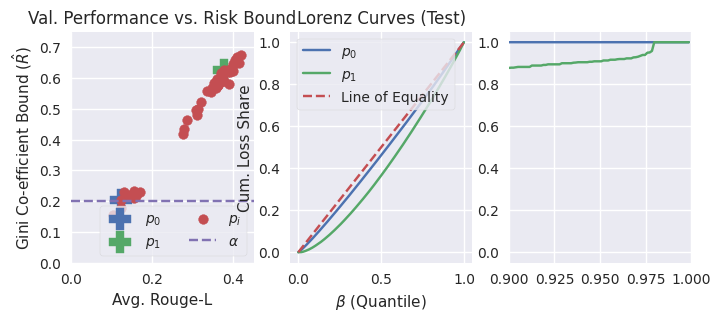

In [3]:
plot_results(
    dataset = "medqsum",
    model_size = 40,
    loss_fn = "rougeL",
    measure="gini",
    n_cal=200,
    left_title = r"Val. Performance vs. Risk Bound",
    right_title=r"Lorenz Curves (Test)",
    alpha=0.2,
    interest_inds = [5,16],
    # interest_inds = [10,16],
    # skip_set = [10],
    save_result=True,
)

In [165]:
measures_map = {
    "var": "VaR",
    "cvar": "CVaR",
    "gini": "Gini"
}

def sample_gini(x):
    # Mean absolute difference
    mad = np.abs(np.subtract.outer(x, x)).mean()
    # Relative mean absolute difference
    rmad = mad/np.mean(x)
    # Gini coefficient
    g = 0.5 * rmad
    return g


def plot_results(
    dataset = "red_team_chat",
    model_size = 40,
    loss_fn = "toxicity",
    n_cal = 1500,
    n_ex=1,
    delta = 0.05,
    num_hypotheses = 50,
    measure="cvar",
    beta_min=0.8, 
    beta_max=1.0, 
    xlim_min=0.0,
    xlim_max=1.0,
    left_title=None,
    right_title=None,
    alpha=0.1,
    interest_inds=[0,1],
    skip_set = [],
    save_result = False,
):

    output_dir = '../llm_output'
    
    sum_df = pd.read_csv(os.path.join(output_dir, "bigbio_meqsum/tiiuae-falcon-{}b-instruct_predictions.csv".format(model_size)))
    print(sum_df.columns)
    
    sum_df = sum_df.drop(['seed', 'max_new_tokens', 'do_sample',
           'stop_sequences', 'response_time', 'tokens_per_second',
           'milliseconds_per_token', 'torch_allocated_GBs',
           'total_GPU_memory_used_GBs', 'GPU_memory_used_GBs', 'finish_reason',
           'generated_tokens'], axis=1)
    
    prompt_list = sum_df["hypothesis"].unique()
    res = []
    for p in prompt_list:
    
        prompt_df = sum_df[sum_df["hypothesis"] == p]
        scores = np.array(prompt_df["rougeL"].tolist())
        queries = [q for q in prompt_df["text"].tolist()]
        responses = prompt_df["generated_text"].tolist()

        if np.mean(scores) < 1.0:
            res.append([
                p,
                1-scores,
                queries,
                responses
            ])
    
        # print(p)
        # print(np.mean(scores), np.std(scores))
        # print(len(scores))
        # print("-------")

    num_hypotheses = len(res)

    torch.manual_seed(0)
    np.random.seed(0)
    random.seed(0)

    pal = plt.rcParams['axes.prop_cycle'].by_key()['color']

    bj_bounds = dict()
    correction = delta/(num_hypotheses-len(skip_set))
    # correction = delta/(num_hypotheses)

    stats = []
    
    plt.rcParams["figure.figsize"] = [9,3]
    fig, axs = plt.subplots(1,2, width_ratios=[4,4])
    plot_dist_idx = [1,12]

    ins_idx = 0
    disp_idx = 0

    best_ins = None
    prc_ins = None

    best_rew = 1.0
    prc_rew = 1.0
    
    for instruction, X, query_texts, chat_responses in res:

        if ins_idx in skip_set:
            ins_idx += 1
            continue

        X_cal = X[:n_cal]
        X_test = X[n_cal:]
    
        text_cal = query_texts[:n_cal]
        text_test = query_texts[n_cal:]
    
        chat_out_cal = chat_responses[:n_cal]
        chat_out_test = chat_responses[n_cal:]        
    
        n_test = X_test.shape[0]

        assert X_cal.shape[0] == n_cal and X_test.shape[0] == n_test
        assert len(chat_out_cal) == n_cal and len(chat_out_test) == n_test
        assert len(text_cal) == n_cal and len(text_test) == n_test
    
        if X_cal.shape[0] not in bj_bounds:
            b = berk_jones(n_cal, correction)
            bj_bounds[n_cal] = b
        else:
            b = bj_bounds[n_cal]
        
        t_cal = np.linspace(0.0, 1.0, n_cal)
        X_cal_sorted = np.sort(X_cal, axis=-1)
        
        t_test = np.linspace(0.0, 1.0, n_test)
        test_ind_sorted = np.argsort(X_test, axis=-1)
        X_test_sorted = X_test[test_ind_sorted]

        emp_mean_cal = integrate_quantiles(np.expand_dims(X_cal, 0), t_cal, beta_min=0.0, beta_max=1.0)[0]
        emp_mean_test = integrate_quantiles(np.expand_dims(X_test, 0), t_test, beta_min=0.0, beta_max=1.0)[0]

        if measure == "mean":
            bound_val = integrate_quantiles(np.expand_dims(X_cal, 0), b, beta_min=0.0, beta_max=1.0)[0]
            emp_val_cal = emp_mean_cal
            emp_val_test = emp_mean_test
        elif measure == "var":
            bound_val = X_cal_sorted[(b < beta_min).astype(int).sum()]
            emp_val_cal = np.quantile(X_cal_sorted, beta_min)
            emp_val_test = np.quantile(X_test_sorted, beta_min)
        elif measure in ["cvar", "var-int"]:
            bound_val = integrate_quantiles(np.expand_dims(X_cal, 0), b, beta_min=beta_min, beta_max=beta_max)[0]
            emp_val_cal = integrate_quantiles(np.expand_dims(X_cal, 0), t_cal, beta_min=beta_min, beta_max=beta_max)[0]
            emp_val_test = integrate_quantiles(np.expand_dims(X_test, 0), t_test, beta_min=beta_min, beta_max=beta_max)[0]
        elif measure == "gini":
            bound_val = calc_gini(np.expand_dims(X_cal, 0), b)[0]
            emp_val_cal = sample_gini(X_cal)
            emp_val_test = sample_gini(X_test)
        else:
            raise ValueError

        # if emp_mean_cal < 0.75:
        #     ins_idx += 1
        #     continue
        # if emp_mean_cal > 0.8:
        #     ins_idx += 1
        #     continue

        s = {
            "idx": ins_idx,
            "instruction": instruction,
            "emp_mean_cal": emp_mean_cal,
            "measure_bound": bound_val,
            "emp_meas_cal": emp_val_cal,
            "emp_meas_test": emp_val_test,
        }
        stats.append(s)

        wind = 3
        
        if ins_idx in interest_inds:

            if bound_val < alpha:
                p_label = r"$p^*_{safe}$"
            else:
                p_label = r"$p^*$"

            # axs[1].plot(np.arange(n_test)/n_test, np.cumsum(X_test_sorted)/np.sum(X_test_sorted), label=p_label, color=pal[disp_idx])

            low_var_ind = int(X_test.shape[0]*(1-beta_min))
            var_text = [text_test[j] for j in list(test_ind_sorted)][low_var_ind-wind:low_var_ind+wind]
            var_chat_out = [chat_out_test[j] for j in list(test_ind_sorted)][low_var_ind-wind:low_var_ind+wind]
            chat_out_betas = [val/X_test.shape[0] for val in range(low_var_ind-wind, low_var_ind+wind+1)]
            chat_out_losses = [X_test_sorted[val] for val in range(low_var_ind-wind, low_var_ind+wind+1)]

            # axs[0].scatter(
            #     1-emp_mean_cal, bound_val, 
            #     label=p_label, 
            #     color=pal[disp_idx], 
            #     marker="P", 
            #     # zorder=1000, 
            #     s=250
            # )
            
            # print("Text@Low VaR:", 1-beta_min)
            # for ctr, v in enumerate(var_chat_out):
            #     print("beta={0:.3f}".format(chat_out_betas[ctr]))
            #     print("loss={0:.3f}".format(chat_out_losses[ctr]))
            #     print(var_text[ctr], v)
            #     print()
            # print()
            
            var_ind = int(X_test.shape[0]*beta_min)
            var_text = [text_test[j] for j in list(test_ind_sorted)][var_ind-wind:var_ind+wind]
            var_chat_out = [chat_out_test[j] for j in list(test_ind_sorted)][var_ind-wind:var_ind+wind]
            chat_out_betas = [val/X_test.shape[0] for val in range(var_ind-wind, var_ind+wind+1)]
            chat_out_losses = [X_test_sorted[val] for val in range(var_ind-wind, var_ind+wind+1)]
            # print("Text@VaR:", beta_min)
            # for ctr, v in enumerate(var_chat_out):
            #     print("beta={0:.3f}".format(chat_out_betas[ctr]))
            #     print("loss={0:.3f}".format(chat_out_losses[ctr]))
            #     print(var_text[ctr], v)
            #     print()
            disp_idx += 1

        if emp_mean_cal < best_rew:
            best_ins = {
                "disp_idx": disp_idx,
                "ins_idx": ins_idx,
                "X_cal": X_cal_sorted,
                "X_test": X_test_sorted,
                "rew_cal": 1-emp_mean_cal,
                "bound_val": bound_val,
                "emp_meas_test": emp_val_test,
            }
            best_rew = emp_mean_cal
            
        if (emp_mean_cal < prc_rew) and (bound_val < alpha):
            prc_ins = {
                "disp_idx": disp_idx,
                "ins_idx": ins_idx,
                "X_cal": X_cal_sorted,
                "X_test": X_test_sorted,
                "rew_cal": 1-emp_mean_cal,
                "bound_val": bound_val,
                "emp_meas_test": emp_val_test,
            }
            prc_rew = emp_mean_cal

        ins_idx += 1

        # if len(stats) >= n_ex:
        #     break

    for s in stats:
        for key, value in s.items():
            print(key, value)

    emp_means = [v["emp_mean_cal"] for v in stats]
    measure_bounds = [v["measure_bound"] for v in stats]
    emp_measure_cal = [v["emp_meas_cal"] for v in stats]
    emp_measure_test = [v["emp_meas_test"] for v in stats]

    # axs[0].scatter(1-np.array(emp_means), measure_bounds, color=pal[2], label=r"$\hat R(p_i)$")
    axs[0].scatter(1-np.array(emp_means), measure_bounds, color=pal[2], label=r"$p_i$")
    axs[0].set_ylim(min(measure_bounds)-0.1, min([max(measure_bounds)+0.2, 1.0]))
    
    axs[0].plot([0.0, 1.0], [alpha, alpha], "--", color=pal[3], label=r"$\alpha$")
    


    # axs[0].set_xlim(0.25, 0.4)
    # axs[0].set_ylim(0.3, 0.45)
    axs[0].set_xlim(0.0, 0.45)
    axs[0].set_ylim(0.0, 0.45)

    print("best", best_ins["ins_idx"])
    print("prc", prc_ins["ins_idx"])

    axs[0].scatter(
        best_ins["rew_cal"], best_ins["bound_val"], 
        label=r"$p^*$", 
        color=pal[0], 
        marker="P", 
        s=250
    )
    axs[1].plot(np.arange(n_test)/n_test, np.cumsum(best_ins["X_test"])/np.sum(best_ins["X_test"]), label=r"$p^*$", color=pal[0])
    
    axs[0].scatter(
        prc_ins["rew_cal"], prc_ins["bound_val"], 
        label=r"$p^*_{safe}$", 
        color=pal[1], 
        marker="P", 
        s=250
    )
    axs[1].plot(np.arange(n_test)/n_test, np.cumsum(prc_ins["X_test"])/np.sum(prc_ins["X_test"]), label=r"$p^*_{safe}$", color=pal[1])

    axs[1].plot([0.0, 1.0], [0.0, 1.0], "--", color=pal[2], label="Line of Equality")

    axs[0].set_xlabel(r"Avg. Rouge-L ($\uparrow$)", fontsize=14)    
    axs[0].set_ylabel(r"Gini Co-efficient Bound ($\hat{R}$)", fontsize=13)    
    axs[1].set_xlabel(r"$\beta$ (Quantile)", fontsize=14)    
    axs[1].set_ylabel("Cum. Loss Share", fontsize=13)    

    axs[0].legend(
        loc="lower right", 
        ncols=2, 
        frameon=True
    )
    axs[1].legend(
        loc="upper left", 
        # ncols=2, 
        frameon=True
    )

    axs[0].set_title(left_title, fontsize=14)    
    axs[1].set_title(right_title, fontsize=14)    
    
    if save_result:
        save_root  = "../plots/{}/{}_model_{}_{}_{}_loss_dist_with_text.png".format(
            dataset,
            dataset, 
            model_size, 
            loss_fn,
            measure,
        )
        print("saving to", save_root)
        plt.savefig(save_root, bbox_inches="tight", dpi=600)

    plt.show()

plot_results(
    dataset = "medqsum",
    model_size = 40,
    loss_fn = "rougeL",
    measure="gini",
    n_cal=600,
    left_title = r"Val. Performance vs. Risk Bound",
    right_title=r"Lorenz Curves (Test)",
    alpha=0.3,
    # interest_inds = [13,9],
    # interest_inds = [13,18],
    skip_set = [22,27],
    save_result=True,
)

In [ ]:
plot_results(
    dataset = "medqsum",
    model_size = 7,
    loss_fn = "rougeL",
    measure="gini",
    n_cal=750,
    left_title = r"Val. Performance vs. Risk Bound",
    right_title=r"Lorenz Curves (Test)",
    alpha=0.3,
    # interest_inds = [13,9],
    # interest_inds = [13,18],
    skip_set = [22,27],
    save_result=True,
)

Index(['id', 'text', 'generated_text', 'seed', 'max_new_tokens', 'do_sample',
       'stop_sequences', 'response_time', 'tokens_per_second',
       'milliseconds_per_token', 'torch_allocated_GBs',
       'total_GPU_memory_used_GBs', 'GPU_memory_used_GBs', 'finish_reason',
       'generated_tokens', 'task_id', 'hypothesis', 'dataset',
       'model_name_or_path', 'generated_summary', 'rougeL', 'hash'],
      dtype='object')
idx 0
instruction {'instruction': "Your goal is to generate a succinct version of the user's question that captures the main points."}
emp_mean_cal 0.82982703581293
measure_bound 0.14632362051932302
emp_meas_cal 0.06988470061125754
emp_meas_test 0.06371527003605933
idx 1
instruction {'instruction': "You are tasked with creating a shortened version of the user's question that retains the main ideas."}
emp_mean_cal 0.8431342446323007
measure_bound 0.13251190229202203
emp_meas_cal 0.06263837989033355
emp_meas_test 0.05699816551317954
idx 2
instruction {'instruction': "Y

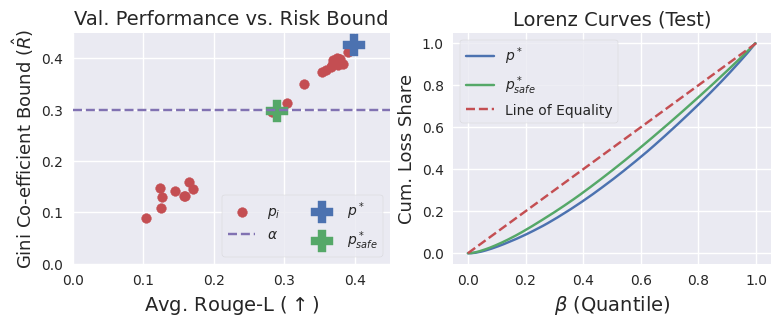

In [168]:
plot_results(
    dataset = "medqsum",
    model_size = 40,
    loss_fn = "rougeL",
    measure="gini",
    n_cal=600,
    left_title = r"Val. Performance vs. Risk Bound",
    right_title=r"Lorenz Curves (Test)",
    alpha=0.3,
    # interest_inds = [13,9],
    # interest_inds = [13,18],
    skip_set = [22,27],
    save_result=True,
)

Index(['id', 'text', 'generated_text', 'seed', 'max_new_tokens', 'do_sample',
       'stop_sequences', 'response_time', 'tokens_per_second',
       'milliseconds_per_token', 'torch_allocated_GBs',
       'total_GPU_memory_used_GBs', 'GPU_memory_used_GBs', 'finish_reason',
       'generated_tokens', 'task_id', 'hypothesis', 'dataset',
       'model_name_or_path', 'generated_summary', 'rougeL'],
      dtype='object')
20
idx 0
instruction {'instruction': "Your goal is to generate a succinct version of the user's question that captures the main points."}
emp_mean_cal 0.8296981237871885
measure_bound 0.15899599298187983
emp_meas_cal 0.06972863342680749
emp_meas_test 0.06511773669675651
idx 1
instruction {'instruction': "You are tasked with creating a shortened version of the user's question that retains the main ideas."}
emp_mean_cal 0.8437036301914695
measure_bound 0.14339513275483262
emp_meas_cal 0.06202305736921141
emp_meas_test 0.05879119286643361
idx 2
instruction {'instruction': "You 

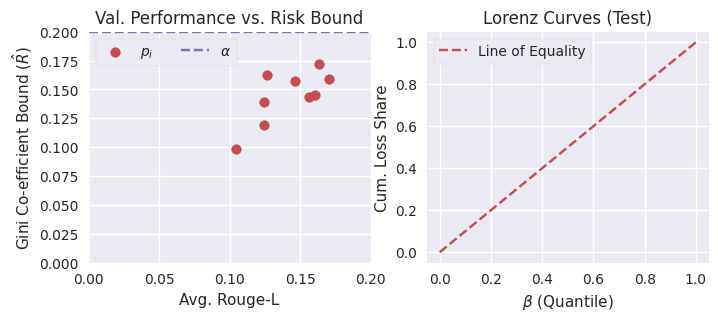

In [22]:
plot_results(
    dataset = "medqsum",
    model_size = 40,
    loss_fn = "rougeL",
    measure="gini",
    n_cal=500,
    left_title = r"Val. Performance vs. Risk Bound",
    right_title=r"Lorenz Curves (Test)",
    alpha=0.2,
    interest_inds = [13,18],
    # skip_set = [10],
    save_result=True,
)

In [165]:
measures_map = {
    "var": "VaR",
    "cvar": "CVaR",
    "gini": "Gini"
}

def sample_gini(x):
    # Mean absolute difference
    mad = np.abs(np.subtract.outer(x, x)).mean()
    # Relative mean absolute difference
    rmad = mad/np.mean(x)
    # Gini coefficient
    g = 0.5 * rmad
    return g


def plot_results(
    dataset = "red_team_chat",
    model_size = "large",
    loss_fn = "toxicity",
    n_cal = 1500,
    n_ex=1,
    delta = 0.05,
    num_hypotheses = 50,
    measure="cvar",
    beta_min=0.8, 
    beta_max=1.0, 
    xlim_min=0.0,
    xlim_max=1.0,
    left_title=None,
    right_title=None,
    alpha=0.1,
    interest_inds=[0,1],
    skip_set = [],
    save_result = False,
    res = res
):
    torch.manual_seed(0)
    np.random.seed(0)
    random.seed(0)

    pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
    
    # load_folder = "../output/{}".format(
    #     dataset, 
    # )
    # load_root = "{}/{}_model_{}_{}_loss_dist_with_text.pkl".format(
    #     load_folder,
    #     dataset, 
    #     model_size, 
    #     loss_fn
    # )
    # print("loading from", load_root)
    
    # with open(load_root, 'rb') as file:
    #     res = pkl.load(file)
    
    bj_bounds = dict()
    correction = delta/(num_hypotheses-len(skip_set))

    stats = []
    
    plt.rcParams["figure.figsize"] = [12,2.5]
    fig, axs = plt.subplots(1,3)
    plot_dist_idx = [1,12]

    ins_idx = 0
    disp_idx = 0
    
    for instruction, X, query_texts, chat_responses in res:

        if ins_idx in skip_set:
            ins_idx += 1
            continue

        X_cal = X[:n_cal]
        X_test = X[n_cal:]
    
        text_cal = query_texts[:n_cal]
        text_test = query_texts[n_cal:]
    
        chat_out_cal = chat_responses[:n_cal]
        chat_out_test = chat_responses[n_cal:]        
    
        n_test = X_test.shape[0]

        assert X_cal.shape[0] == n_cal and X_test.shape[0] == n_test
        assert len(chat_out_cal) == n_cal and len(chat_out_test) == n_test
        assert len(text_cal) == n_cal and len(text_test) == n_test
    
        if X_cal.shape[0] not in bj_bounds:
            b = berk_jones(n_cal, correction)
            bj_bounds[n_cal] = b
        else:
            b = bj_bounds[n_cal]
        
        t_cal = np.linspace(0.0, 1.0, n_cal)
        X_cal_sorted = np.sort(X_cal, axis=-1)
        
        t_test = np.linspace(0.0, 1.0, n_test)
        test_ind_sorted = np.argsort(X_test, axis=-1)
        X_test_sorted = X_test[test_ind_sorted]

        emp_mean_cal = integrate_quantiles(np.expand_dims(X_cal, 0), t_cal, beta_min=0.0, beta_max=1.0)[0]
        emp_mean_test = integrate_quantiles(np.expand_dims(X_test, 0), t_test, beta_min=0.0, beta_max=1.0)[0]

        if measure == "mean":
            bound_val = integrate_quantiles(np.expand_dims(X_cal, 0), b, beta_min=0.0, beta_max=1.0)[0]
            emp_val_cal = emp_mean_cal
            emp_val_test = emp_mean_test
        elif measure == "var":
            bound_val = X_cal_sorted[(b < beta_min).astype(int).sum()]
            emp_val_cal = np.quantile(X_cal_sorted, beta_min)
            emp_val_test = np.quantile(X_test_sorted, beta_min)
        elif measure in ["cvar", "var-int"]:
            bound_val = integrate_quantiles(np.expand_dims(X_cal, 0), b, beta_min=beta_min, beta_max=beta_max)[0]
            emp_val_cal = integrate_quantiles(np.expand_dims(X_cal, 0), t_cal, beta_min=beta_min, beta_max=beta_max)[0]
            emp_val_test = integrate_quantiles(np.expand_dims(X_test, 0), t_test, beta_min=beta_min, beta_max=beta_max)[0]
        elif measure == "gini":
            bound_val = calc_gini(np.expand_dims(X_cal, 0), b)[0]
            emp_val_cal = sample_gini(X_cal)
            emp_val_test = sample_gini(X_test)
        else:
            raise ValueError

        if emp_mean_cal > 0.8:
            ins_idx += 1
            continue

        s = {
            "idx": ins_idx,
            "emp_mean_cal": emp_mean_cal,
            "measure_bound": bound_val,
            "emp_meas_cal": emp_val_cal,
            "emp_meas_test": emp_val_test,
        }
        stats.append(s)

        wind = 3
        
        if ins_idx in interest_inds:

            axs[1].plot(b, X_cal_sorted, "--", label=r"$B^U_{}$".format(disp_idx), color=pal[disp_idx])
            axs[1].plot(np.arange(n_cal)/n_cal, X_cal_sorted, label=r"$F^-_{}$".format(disp_idx), color=pal[disp_idx])

            # axs[2].plot(b, X_test_sorted, "--", label=r"$B^U_{}$".format(disp_idx), color=pal[interest_inds.index(ins_idx)])
            axs[2].plot(np.arange(n_test)/n_test, np.cumsum(X_test_sorted)/np.sum(X_test_sorted), label=r"$p_{}$".format(disp_idx), color=pal[disp_idx])

            low_var_ind = int(X_test.shape[0]*(1-beta_min))
            var_text = [text_test[j] for j in list(test_ind_sorted)][low_var_ind-wind:low_var_ind+wind]
            var_chat_out = [chat_out_test[j] for j in list(test_ind_sorted)][low_var_ind-wind:low_var_ind+wind]
            chat_out_betas = [val/X_test.shape[0] for val in range(low_var_ind-wind, low_var_ind+wind+1)]
            chat_out_losses = [X_test_sorted[val] for val in range(low_var_ind-wind, low_var_ind+wind+1)]

            axs[0].scatter(
                1-emp_mean_cal, bound_val, 
                label=r"$\hat R(p_{})$".format(disp_idx), 
                color=pal[disp_idx], 
                marker="P", 
                # zorder=1000, 
                s=250
            )
            
            # print("Text@Low VaR:", 1-beta_min)
            # for ctr, v in enumerate(var_chat_out):
            #     print("beta={0:.3f}".format(chat_out_betas[ctr]))
            #     print("loss={0:.3f}".format(chat_out_losses[ctr]))
            #     print(var_text[ctr], v)
            #     print()
            # print()
            
            var_ind = int(X_test.shape[0]*beta_min)
            var_text = [text_test[j] for j in list(test_ind_sorted)][var_ind-wind:var_ind+wind]
            var_chat_out = [chat_out_test[j] for j in list(test_ind_sorted)][var_ind-wind:var_ind+wind]
            chat_out_betas = [val/X_test.shape[0] for val in range(var_ind-wind, var_ind+wind+1)]
            chat_out_losses = [X_test_sorted[val] for val in range(var_ind-wind, var_ind+wind+1)]
            # print("Text@VaR:", beta_min)
            # for ctr, v in enumerate(var_chat_out):
            #     print("beta={0:.3f}".format(chat_out_betas[ctr]))
            #     print("loss={0:.3f}".format(chat_out_losses[ctr]))
            #     print(var_text[ctr], v)
            #     print()
            disp_idx += 1

        ins_idx += 1

        # if len(stats) >= n_ex:
        #     break

    for s in stats:
        print(s)

    emp_means = [v["emp_mean_cal"] for v in stats]
    measure_bounds = [v["measure_bound"] for v in stats]
    emp_measure_cal = [v["emp_meas_cal"] for v in stats]
    emp_measure_test = [v["emp_meas_test"] for v in stats]

    axs[0].scatter(1-np.array(emp_means), measure_bounds, color=pal[2], label=r"$\hat R(p_i)$")
    axs[0].set_ylim(min(measure_bounds)-0.1, min([max(measure_bounds)+0.2, 1.0]))
    
    axs[0].plot([0.0, 1.0], [alpha, alpha], "--", color=pal[3], label=r"$\alpha$")
    axs[0].set_xlabel("Avg. Rouge-L")
    # axs[0].set_ylabel(r"$\hat R$")
    axs[0].set_ylabel(measures_map[measure] + " Risk Bound")

    axs[1].set_xlabel(r"$\beta$ (Quantile)")
    axs[1].set_ylabel("Loss Value")

    axs[2].set_xlabel(r"$\beta$ (Quantile)")

    # axs[0].legend(
    #     loc="lower left", 
    #     ncols=2, frameon=True)
    # axs[1].legend(
    #     loc="upper left", 
    #     ncols=2, frameon=True)

    axs[0].set_title(left_title)
    axs[1].set_title("Inverse CDF and Bound")
    if right_title is None:
        axs[2].set_title("Inverse CDF and Bound (Zoom)")
    else:
        axs[2].set_title(right_title)

    # if measure == "var":
    #     axs[2].set_xlim(beta_min-0.05, beta_min+0.05)
    #     axs[2].plot([beta_min, beta_min], [0,1], "--", color="k")
    # else:
    # axs[2].set_xlim(beta_min, 1)
    # axs[2].set_ylim(0.6, 1)
    axs[0].set_xlim(0.25, 0.4)
    axs[2].plot([0.0, 1.0], [0.0, 1.0], color=pal[2])

    if save_result:
        save_root  = "../plots/{}/{}_model_{}_{}_{}_loss_dist_with_text.png".format(
            dataset,
            dataset, 
            model_size, 
            loss_fn,
            measure,
        )
        plt.savefig(save_root, bbox_inches="tight")

    plt.show()

{'idx': 9, 'emp_mean_cal': 0.6348393997915935, 'measure_bound': 0.5459475854574345, 'emp_meas_cal': 0.20624356777098912, 'emp_meas_test': 0.20306243768534882}
{'idx': 10, 'emp_mean_cal': 0.720713757413882, 'measure_bound': 0.39180782972000405, 'emp_meas_cal': 0.14976105037463958, 'emp_meas_test': 0.15414756938376298}
{'idx': 11, 'emp_mean_cal': 0.6677369898637961, 'measure_bound': 0.506986652631723, 'emp_meas_cal': 0.196698635861025, 'emp_meas_test': 0.17143176197960047}
{'idx': 12, 'emp_mean_cal': 0.6229892351752173, 'measure_bound': 0.5517802833302634, 'emp_meas_cal': 0.20617927053207502, 'emp_meas_test': 0.19594520014914246}
{'idx': 13, 'emp_mean_cal': 0.6931913641284582, 'measure_bound': 0.447523616561339, 'emp_meas_cal': 0.17251094700840783, 'emp_meas_test': 0.16011553036871337}
{'idx': 14, 'emp_mean_cal': 0.717720812559145, 'measure_bound': 0.4182553104850171, 'emp_meas_cal': 0.16240438407389282, 'emp_meas_test': 0.15455765505616467}
{'idx': 15, 'emp_mean_cal': 0.6456162434086321

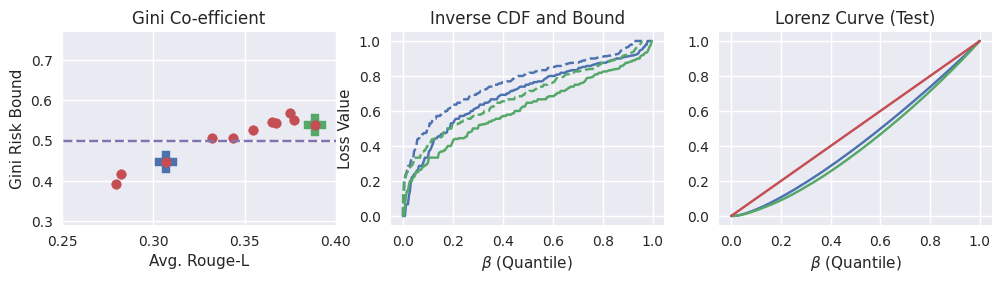

In [166]:
plot_results(
    dataset = "medqsum",
    model_size = "xl",
    loss_fn = "rougeL",
    measure="gini",
    beta_min = 0.9,
    n_cal=250,
    n_ex=2,
    left_title=r"Gini Co-efficient",
    right_title=r"Lorenz Curve (Test)",
    alpha=0.5,
    interest_inds = [13,18],
    # skip_set = [3,4,7,8],
    save_result=False,
    res = res
)